This notebook looks at the Kump 2018 taxonomy, specifically looking for butyrate-producers in the donors.

In [30]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('white')

In [31]:
ftax = '../../data/qiime-proc/kump2018/exported_data/kump2018.taxonomy.gg-13-8-99.tsv'
fotu = '../../data/qiime-proc/kump2018/exported_data/kump2018.feature-table.txt'
fmeta = '../../data/raw/kump2018/mapping_file.txt'
ftaxsilva = '../../data/qiime-proc/kump2018/exported_data/kump2018.taxonomy.silva-132-99.tsv'

# out files
ftidy = '../../data/clean/kump2018.tidy_otu_w_taxonomy.txt'

# Clean up taxonomy

Need to:
- check that confidences are all "high enough"
- add unannotated taxonomic levels (so the taxa strings are all same length)

**Note: I moved this stuff to src/data/add_taxonomy_and_tidy_table.py**

### Start with GG-assigned taxonomy

In [32]:
taxgg = pd.read_csv(ftax, sep='\t')
taxgg.head()

,Feature ID,Taxon,Confidence
0,e0a05e5465157a68916b185f11c680fd,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.798158
1,76382402381bb0d86fffcc1727eace56,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.719387
2,92cc2d850c28edf795d179eb42e219da,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.728053
3,97a05c1c6cf55eeb7cc709e2c5445b87,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.770913
4,fc97272b80b47e03b74c9ffad8a3b2da,k__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.999940


In [33]:
taxgg.sort_values(by='Confidence').head()

,Feature ID,Taxon,Confidence
178,f229ef2a63af7bb4cb00c4eb53a1b456,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.700785
601,c5296076aa1f386999571c2d636f35b2,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.700813
1474,4c817904508b1a7f24f328e2e59cd9f4,k__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.700921
2276,59465fd17c7007e92e7cfe67faa9c55c,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.700982
1961,abd0658003f574011e801017667db01a,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.701024


Okay, looks like the confidence cutoff was 70% (I used the qiime2 defaults, which I'm going to assume are sensible!)

Next: do some strip manipulations so the OTU ID has all taxonomic levels labeled, no white spaces, and also has the original ASV feature ID.

Let's start with GreenGenes and add the SILVA taxonomy later as well.

In [34]:
def fix_gg_tax_string(t):
    """
    t is a string returned by the GG sklearn qiime2 classifier.
    This function splits t by semicolon and removes trailing spaces, 
    and returns a taxonomic string with missing levels filled in.
    
    e.g. input:  'k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae'
         output: 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__'  
    """

    t = [i.strip() for i in t.split(';')]
    missing_taxa = ['k__', 'p__', 'c__', 'o__', 'f__', 'g__', 's__']
    
    return ';'.join(t + missing_taxa[len(t):])

def return_gg_otu(row):
    return fix_gg_tax_string(row['Taxon']) + ';d__' + row['Feature ID']

In [35]:
taxgg['otu_id'] = taxgg.apply(lambda row: return_gg_otu(row), axis=1)

In [36]:
taxgg.head()

,Feature ID,Taxon,Confidence,otu_id
0,e0a05e5465157a68916b185f11c680fd,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.798158,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
1,76382402381bb0d86fffcc1727eace56,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.719387,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
2,92cc2d850c28edf795d179eb42e219da,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.728053,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
3,97a05c1c6cf55eeb7cc709e2c5445b87,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.770913,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
4,fc97272b80b47e03b74c9ffad8a3b2da,k__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.999940,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...


### Also add the Silva taxonomy

In [37]:
taxsilva = pd.read_csv(ftaxsilva, sep='\t')
taxsilva.sort_values(by='Confidence').head()

,Feature ID,Taxon,Confidence
1219,70088763e5049262b0955180edd604ae,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,0.700049
2048,ec4c5694e63fcdf5c2b57c23acf465cb,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,0.700177
1096,31e29e9c7118e5f22f57da2ff592fb93,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,0.700333
1408,ccf9bcf5a41e3b370d67eb90a5b5e398,D_0__Bacteria;D_1__Firmicutes;D_2__Bacilli;D_3...,0.700570
2217,fcf1a7b1583c8da4c1b294c7c2534549,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,0.701012


In [38]:
def fix_silva_tax_string(t):
    """
    t is a string returned by the GG sklearn qiime2 classifier.
    This function splits t by semicolon and removes trailing spaces, 
    and returns a taxonomic string with missing levels filled in.
    
    e.g. input:  'D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;D_3__Clostridiales;D_4__Lachnospiraceae'
         output: 'D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;D_3__Clostridiales;D_4__Lachnospiraceae;D_5__;D_6__;D_7__e0a05e5465157a68916b185f11c680fd'
    """

    t = [''.join(i.strip().split()) for i in t.split(';')]
    missing_taxa = ['D_' + str(i) + '__' for i in range(7)]
    
    return ';'.join(t + missing_taxa[len(t):])

def return_silva_otu(row):
    return fix_silva_tax_string(row['Taxon']) + ';D_7__' + row['Feature ID']

In [39]:
taxsilva['otu_id'] = taxsilva.apply(lambda row: return_silva_otu(row), axis=1)

# Prepare tidy OTU table

Since we'll eventually be grouping by genus (I think), let's convert our wide OTU table into tidy data. 

In [40]:
df = pd.read_csv(fotu, sep='\t', skiprows=1, index_col=0).T
# Get total reads per sample (to later convert to relative abundance)
df['total_reads'] = df.sum(axis=1)
df.index.name = 'sample_id'

df.head()

#OTU ID,15a4ec059938586486459a6c1a0c2066,fc83bc48e9279bcdd33a044c7850db87,fa1c8f379734fab0c94b08204bcb38da,f8f05a09d1fe9e4726e176e7c9601b13,29e7a6df9c32f633115dece6b0d1126f,a9a07d731fbd88dcb9b6c0f068eedcb4,0cca81d6981d4d27a017cac66e633572,7c65d52949244cfd1e8ccd4d832bca45,90f837a239f68c0e3f771b576e283c61,ed6f83d2a35ff95912af54ab50bbdaec,...,714305a573b93cda2ee107d52ec124e4,3ec64d21748164ce9c3f96425640aed1,208acf4c498e6c6e6c034469722ca93a,67241ff30051d456d9ce6f192d712cd7,9c92574f8c56a5fb64618293fd41b0c2,c1c5816d36a728fc45f6f51ab3ca465d,17be32d789d6938a84798fb7b8558f33,b20dde5c07f8e8765312754cb3b395ba,db1a36d554afbf7ea8d20be216a3872e,total_reads
sample_id,,,,,,,,,,,,,,,,,,,,,
173,1767.0,1522.0,1242.0,1082.0,1003.0,824.0,818.0,794.0,668.0,629.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25545.0
202,0.0,797.0,0.0,0.0,0.0,250.0,1738.0,373.0,1323.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29917.0
195,0.0,681.0,0.0,0.0,0.0,242.0,0.0,0.0,878.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20086.0
194,0.0,2093.0,0.0,0.0,0.0,302.0,7.0,1032.0,2204.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30770.0
79,0.0,727.0,0.0,0.0,0.0,747.0,0.0,392.0,931.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21282.0


In [41]:
tidydf = (df
    .reset_index()
    .melt(id_vars=['sample_id', 'total_reads'], value_name='reads')
)
tidydf.head()

,sample_id,total_reads,#OTU ID,reads
0,173,25545.0,15a4ec059938586486459a6c1a0c2066,1767.0
1,202,29917.0,15a4ec059938586486459a6c1a0c2066,0.0
2,195,20086.0,15a4ec059938586486459a6c1a0c2066,0.0
3,194,30770.0,15a4ec059938586486459a6c1a0c2066,0.0
4,79,21282.0,15a4ec059938586486459a6c1a0c2066,0.0


In [42]:
# Rename taxa df columns
taxgg.columns = [i + '_gg' for i in taxgg.columns]
taxsilva.columns = [i + '_silva' for i in taxsilva.columns]

In [43]:
# Now add the OTU ID from GG
tidydf = pd.merge(tidydf, taxgg, how='left', left_on='#OTU ID', right_on='Feature ID_gg')
tidydf.head()

,sample_id,total_reads,#OTU ID,reads,Feature ID_gg,Taxon_gg,Confidence_gg,otu_id_gg
0,173,25545.0,15a4ec059938586486459a6c1a0c2066,1767.0,15a4ec059938586486459a6c1a0c2066,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.997215,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
1,202,29917.0,15a4ec059938586486459a6c1a0c2066,0.0,15a4ec059938586486459a6c1a0c2066,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.997215,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
2,195,20086.0,15a4ec059938586486459a6c1a0c2066,0.0,15a4ec059938586486459a6c1a0c2066,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.997215,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
3,194,30770.0,15a4ec059938586486459a6c1a0c2066,0.0,15a4ec059938586486459a6c1a0c2066,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.997215,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
4,79,21282.0,15a4ec059938586486459a6c1a0c2066,0.0,15a4ec059938586486459a6c1a0c2066,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.997215,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...


In [44]:
# And from SILVA
tidydf = pd.merge(tidydf, taxsilva, how='left', left_on='#OTU ID', right_on='Feature ID_silva')
tidydf.head()

,sample_id,total_reads,#OTU ID,reads,Feature ID_gg,Taxon_gg,Confidence_gg,otu_id_gg,Feature ID_silva,Taxon_silva,Confidence_silva,otu_id_silva
0,173,25545.0,15a4ec059938586486459a6c1a0c2066,1767.0,15a4ec059938586486459a6c1a0c2066,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.997215,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,15a4ec059938586486459a6c1a0c2066,D_0__Bacteria;D_1__Firmicutes;D_2__Negativicut...,0.995795,D_0__Bacteria;D_1__Firmicutes;D_2__Negativicut...
1,202,29917.0,15a4ec059938586486459a6c1a0c2066,0.0,15a4ec059938586486459a6c1a0c2066,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.997215,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,15a4ec059938586486459a6c1a0c2066,D_0__Bacteria;D_1__Firmicutes;D_2__Negativicut...,0.995795,D_0__Bacteria;D_1__Firmicutes;D_2__Negativicut...
2,195,20086.0,15a4ec059938586486459a6c1a0c2066,0.0,15a4ec059938586486459a6c1a0c2066,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.997215,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,15a4ec059938586486459a6c1a0c2066,D_0__Bacteria;D_1__Firmicutes;D_2__Negativicut...,0.995795,D_0__Bacteria;D_1__Firmicutes;D_2__Negativicut...
3,194,30770.0,15a4ec059938586486459a6c1a0c2066,0.0,15a4ec059938586486459a6c1a0c2066,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.997215,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,15a4ec059938586486459a6c1a0c2066,D_0__Bacteria;D_1__Firmicutes;D_2__Negativicut...,0.995795,D_0__Bacteria;D_1__Firmicutes;D_2__Negativicut...
4,79,21282.0,15a4ec059938586486459a6c1a0c2066,0.0,15a4ec059938586486459a6c1a0c2066,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.997215,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,15a4ec059938586486459a6c1a0c2066,D_0__Bacteria;D_1__Firmicutes;D_2__Negativicut...,0.995795,D_0__Bacteria;D_1__Firmicutes;D_2__Negativicut...


In [45]:
#tidydf.to_csv(ftidy, sep='\t', index=False)
tidydf = pd.read_csv(ftidy, sep='\t')

# Look for some butyrate producers

Let's just look and see how many of those 16 taxa are even in here...

The taxa from the "[Colonic Butyrate-Producing Communities in Humans: an Overview Using Omics Data](https://msystems.asm.org/content/2/6/e00130-17)" paper are:

- Odoribacter
    - Table S2: 5/5 genomes have Acetyl-CoA
- E. ventriosum
    - this is part of Lachnospiraceae_incertae_sedis
    - 1/1 genomes have Acetyl-CoA
- E. hallii
    - 3/3 E. hallii genomes have Acetyl-CoA
    - this is one of the Lachno incertae sedis species
- E. rectale
    - 7/7 genomes have Acetyl-CoA
    - this is one of the Lachno incertae sedis species
- B. crossotus
    - this one is not present in >70% of people, it was just added to Fig 1 bc it's high abundance in a few people
- S. variabile
    - this was the only subdoligranulum genome (and does have Acetyl-CoA)
- ClostridiumXIVa
    - 42% of the 75 genomes have Acetyl-CoA
    - Paper doesn't address this low percentage, and in fact includes Clostridium XIVa as part of the "global core community"
- Coprococcus
    - 92% of the 13 genomes have Acetyl-CoA
- Butyricicoccus
    - 3/3 genomes have Acetyl-CoA
- Pseudoflavonifractor
    - 66% of 3 genomes have Acetyl-Coa
- Flavonifractor
    - 10/10 genomes have Acetyl-CoA
- Anaerostipes
    - 14/14 genomes have Acetyl-CoA
- R. intestinalis, R. inulinivorans, and R. faecis
    - 12/12 Roseburia genomes have Acetyl-CoA 
    - "Manual inspections of major, abundant  genera led us to resolve Roseburia and Lachnospiraceae incertae sedis at the species level, as sequences  of individual species displayed high phylogenetic distances for all pathway genes"
- Oscillibacter
    - 83% of 6 genomes have Acetyl-CoA
- F. prausnitzii
    - 7/7 Faecalibacterium genomes have Acetyl-CoA
    - "For genera that encompassed only one species, such as F. prausnitzii and S. variabile, the species name is displayed."


Let's start with the easy ones (genus-level):

Odoribacter   
ClostridiumXIVa   
Coprococcus   
Butyricicoccus   
Pseudoflavonifractor   
Flavonifractor   
Anaerostipes   
Roseburia   
Oscillibacter   
Faecalibacterium   
Subdoligranulum

In [46]:
genera = ['Odoribacter', 
          'Clostridium_XIVa',
          'Coprococcus',
          'Butyricicoccus',
          'Pseudoflavonifractor',
          'Flavonifractor',
          'Anaerostipes',
          'Roseburia',
          'Oscillibacter',
          'Faecalibacterium',
          'Subdoligranulum'
         ]

alltaxa_gg = tidydf['otu_id_gg'].unique().tolist()

for g in genera:
    print(g)
    tmp = [i for i in alltaxa_gg if 'g__' + g in i]
    tmp = set([i.rsplit(';', 1)[0] for i in tmp])
    print('\n'.join(tmp) + '\n')
    

Odoribacter
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Odoribacteraceae];g__Odoribacter;s__

Clostridium_XIVa


Coprococcus
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__catus
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__eutactus

Butyricicoccus
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Butyricicoccus;s__pullicaecorum

Pseudoflavonifractor


Flavonifractor


Anaerostipes
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Anaerostipes;s__

Roseburia
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Roseburia;s__faecis
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Roseburia;s__

Oscillibacter


Faecalibacterium
k__Bacteria;p__Firmicutes;c__Clostridia;o_

Okay, so looks like we can't find any Clostridium XIVa, Pseudoflavnoifractor, Flavonifractor, or Oscillibacter. This might be bc we used Green Genes...?

In [47]:
alltaxa_silva = tidydf['otu_id_silva'].unique().tolist()

for g in genera:
    print(g)
    tmp = [i for i in alltaxa_silva if g in i]
    tmp = set([i.rsplit(';', 1)[0] for i in tmp])
    print('\n'.join(tmp) + '\n')
    

Odoribacter
D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroidia;D_3__Bacteroidales;D_4__Marinifilaceae;D_5__Odoribacter;D_6__gutmetagenome
D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroidia;D_3__Bacteroidales;D_4__Marinifilaceae;D_5__Odoribacter;D_6__

Clostridium_XIVa


Coprococcus
D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;D_3__Clostridiales;D_4__Lachnospiraceae;D_5__Coprococcus2;D_6__
D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;D_3__Clostridiales;D_4__Lachnospiraceae;D_5__Coprococcus3;D_6__
D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;D_3__Clostridiales;D_4__Lachnospiraceae;D_5__Coprococcus2;D_6__unculturedCoprococcussp.
D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;D_3__Clostridiales;D_4__Lachnospiraceae;D_5__Coprococcus1;D_6__

Butyricicoccus
D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;D_3__Clostridiales;D_4__Ruminococcaceae;D_5__Butyricicoccus;D_6__Butyricicoccuspullicaecorum1.2
D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;D_3__Clostridiales;D_4__Ruminococcaceae;D_5__Butyri

# Butyrate producer abundance with different taxonomy classifications

Let's see if the total abundance of butyrate producers is significantly affected by which taxonomy classification I use. Hopefully it won't be...!

In [48]:
# First, make a list of the OTUs that are butyrate producing genera
but_silva = []
for g in genera:
    but_silva += [i for i in alltaxa_silva if g in i]
but_silva = list(set(but_silva))

but_gg = []
for g in genera:
    but_gg += [i for i in alltaxa_gg if g in i]
but_gg = list(set(but_gg))

print(len(but_gg), len(but_silva))

(167, 149)


Uh oh, already not looking great. But maybe that's because the SILVA database is smaller? Anyway, let's keep going.

In [49]:
# Add relative abundance column
tidydf['rel_abun'] = tidydf['reads'] / tidydf['total_reads']

In [50]:
but_abun_gg = tidydf.query('otu_id_gg == @but_gg').groupby('sample_id').sum()['rel_abun']
but_abun_silva = tidydf.query('otu_id_silva == @but_silva').groupby('sample_id').sum()['rel_abun']

(0, 0.5)

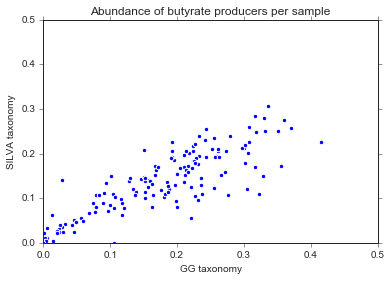

In [51]:
data = pd.merge(
    but_abun_gg.reset_index(name='gg_abun'), 
    but_abun_silva.reset_index(name='silva_abun'))

plt.scatter(data['gg_abun'], data['silva_abun'])
plt.xlabel('GG taxonomy')
plt.ylabel('SILVA taxonomy')
plt.title('Abundance of butyrate producers per sample')
plt.ylim([0, 0.5])
plt.xlim([0, 0.5])

Okay, this looks pretty correlated. In general the GG taxonomy gives much higher abundance of butyrate producers - let's go with this one!

# Butyrate producers in donors

Next, let's look at the abundance of these bugs in the donors, stratified by whether their patient was a responder or non-responder.

In [52]:
meta = pd.read_csv(fmeta, sep='\t', index_col=0)
meta.index = [str(i) for i in meta.index]
meta.head()

,Forward_read,Reverse_read,Matter,Identity,PatientID,DonorID,Response,Sampletype,prepost,Sampling_day
34,34_S35_L001_R1_001.fastq,34_S35_L001_R2_001.fastq,Stool Patient,PD_S-10,PD,DB,NR,Patientstool,preABX,d-10
35,35_S36_L001_R1_001.fastq,35_S36_L001_R2_001.fastq,Stool Patient,PD_S1,PD,DB,NR,Patientstool,postABX,d1
36,36_S37_L001_R1_001.fastq,36_S37_L001_R2_001.fastq,Stool Patient,PD_S14,PD,DB,NR,Patientstool,postFMT,d14
37,37_S38_L001_R1_001.fastq,37_S38_L001_R2_001.fastq,Stool Patient,PD_S28,PD,DB,NR,Patientstool,postFMT,d28
38,38_S39_L001_R1_001.fastq,38_S39_L001_R2_001.fastq,Stool Patient,PD_S42,PD,DB,NR,Patientstool,postFMT,d42


In [53]:
meta.query('Sampletype == "Donorstool"').query('Sampling_day == "d1"')

,Forward_read,Reverse_read,Matter,Identity,PatientID,DonorID,Response,Sampletype,prepost,Sampling_day
41,41_S42_L001_R1_001.fastq,41_S42_L001_R2_001.fastq,Donorstool,PD_D1,PD,DB,NR,Donorstool,Donorstool,d1
51,51_S52_L001_R1_001.fastq,51_S52_L001_R2_001.fastq,Donorstool,PE_D1,PE,DC,RE,Donorstool,Donorstool,d1
66,66_S68_L001_R1_001.fastq,66_S68_L001_R2_001.fastq,Donorstool,PF_D1,PF,DD,PR,Donorstool,Donorstool,d1
82,82_S84_L001_R1_001.fastq,82_S84_L001_R2_001.fastq,Donorstool,PG_D1,PG,DE,PR,Donorstool,Donorstool,d1
112,112_S115_L001_R1_001.fastq,112_S115_L001_R2_001.fastq,Donorstool,PI_D1,PI,DG,RE,Donorstool,Donorstool,d1
141,141_S7_L001_R1_001.fastq,141_S7_L001_R2_001.fastq,Donorstool,PK_D1,PK,DC,PR,Donorstool,Donorstool,d1
171,171_S38_L001_R1_001.fastq,171_S38_L001_R2_001.fastq,Donorstool,PM_D1,PM,DJ,NR,Donorstool,Donorstool,d1
184,184_S51_L001_R1_001.fastq,184_S51_L001_R2_001.fastq,Donorstool,PN_D1,PN,DK,RE,Donorstool,Donorstool,d1
199,199_S67_L001_R1_001.fastq,199_S67_L001_R2_001.fastq,Donorstool,PO_D1,PO,DL,RE,Donorstool,Donorstool,d1
216,216_S84_L001_R1_001.fastq,216_S84_L001_R2_001.fastq,Donorstool,PP_D1,PP,DM,PR,Donorstool,Donorstool,d1


In [54]:
meta.query('Sampletype == "Donorstool"').groupby(['DonorID', 'Sampling_day']).size()

DonorID  Sampling_day
DB       d1              1
DC       d1              2
         d14             1
         d28             1
         d42             2
         d56             2
DD       d1              1
         d14             1
         d28             1
         d42             1
         d56             1
DE       d1              1
         d14             1
         d42             1
         d56             1
DF       d14             1
         d28             1
         d42             1
         d56             1
DG       d1              1
         d14             1
         d28             1
         d42             1
         d56             1
DI       d14             1
         d28             1
         d42             1
DJ       d1              1
         d14             1
         d28             1
         d42             1
DK       d1              1
         d28             1
         d42             1
DL       d1              1
         d14             1
      

In [55]:
meta.query('DonorID == "DI"')

,Forward_read,Reverse_read,Matter,Identity,PatientID,DonorID,Response,Sampletype,prepost,Sampling_day
151,151_S17_L001_R1_001.fastq,151_S17_L001_R2_001.fastq,Stool Patient,PL_S-10,PL,DI,NR,Patientstool,preABX,d-10
152,152_S18_L001_R1_001.fastq,152_S18_L001_R2_001.fastq,Stool Patient,PL_S1,PL,DI,NR,Patientstool,postABX,d1
153,153_S19_L001_R1_001.fastq,153_S19_L001_R2_001.fastq,Stool Patient,PL_S3,PL,DI,NR,Patientstool,postFMT,d3
154,154_S20_L001_R1_001.fastq,154_S20_L001_R2_001.fastq,Stool Patient,PL_S28,PL,DI,NR,Patientstool,postFMT,d28
155,155_S21_L001_R1_001.fastq,155_S21_L001_R2_001.fastq,Stool Patient,PL_S42,PL,DI,NR,Patientstool,postFMT,d42
156,156_S23_L001_R1_001.fastq,156_S23_L001_R2_001.fastq,Stool Patient,PL_S56,PL,DI,NR,Patientstool,postFMT,d56
157,157_S24_L001_R1_001.fastq,157_S24_L001_R2_001.fastq,Donorstool,PL_D14,PL,DI,NR,Donorstool,Donorstool,d14
158,158_S25_L001_R1_001.fastq,158_S25_L001_R2_001.fastq,Donorstool,PL_D28,PL,DI,NR,Donorstool,Donorstool,d28
159,159_S26_L001_R1_001.fastq,159_S26_L001_R2_001.fastq,Donorstool,PL_D42,PL,DI,NR,Donorstool,Donorstool,d42


Donor DI doesn't have a day 1 sample. Oh well!

## Combine tidy OTU table with metadata

In [56]:
tidydf['sample_id'] = tidydf['sample_id'].astype(str)
tidydf = pd.merge(tidydf, meta, left_on='sample_id', right_index=True)

In [58]:
tidydf.head()

,sample_id,total_reads,#OTU ID,reads,Feature ID_gg,Taxon_gg,Confidence_gg,otu_id_gg,Feature ID_silva,Taxon_silva,...,Forward_read,Reverse_read,Matter,Identity,PatientID,DonorID,Response,Sampletype,prepost,Sampling_day
0,173,25545.0,15a4ec059938586486459a6c1a0c2066,1767.0,15a4ec059938586486459a6c1a0c2066,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.997215,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,15a4ec059938586486459a6c1a0c2066,D_0__Bacteria;D_1__Firmicutes;D_2__Negativicut...,...,173_S40_L001_R1_001.fastq,173_S40_L001_R2_001.fastq,Donorstool,PM_D28,PM,DJ,NR,Donorstool,Donorstool,d28
172,173,25545.0,fc83bc48e9279bcdd33a044c7850db87,1522.0,fc83bc48e9279bcdd33a044c7850db87,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.998749,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,fc83bc48e9279bcdd33a044c7850db87,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,...,173_S40_L001_R1_001.fastq,173_S40_L001_R2_001.fastq,Donorstool,PM_D28,PM,DJ,NR,Donorstool,Donorstool,d28
344,173,25545.0,fa1c8f379734fab0c94b08204bcb38da,1242.0,fa1c8f379734fab0c94b08204bcb38da,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.993184,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,fa1c8f379734fab0c94b08204bcb38da,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,...,173_S40_L001_R1_001.fastq,173_S40_L001_R2_001.fastq,Donorstool,PM_D28,PM,DJ,NR,Donorstool,Donorstool,d28
516,173,25545.0,f8f05a09d1fe9e4726e176e7c9601b13,1082.0,f8f05a09d1fe9e4726e176e7c9601b13,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.998904,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,f8f05a09d1fe9e4726e176e7c9601b13,D_0__Bacteria;D_1__Firmicutes;D_2__Negativicut...,...,173_S40_L001_R1_001.fastq,173_S40_L001_R2_001.fastq,Donorstool,PM_D28,PM,DJ,NR,Donorstool,Donorstool,d28
688,173,25545.0,29e7a6df9c32f633115dece6b0d1126f,1003.0,29e7a6df9c32f633115dece6b0d1126f,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.997809,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,29e7a6df9c32f633115dece6b0d1126f,D_0__Bacteria;D_1__Firmicutes;D_2__Negativicut...,...,173_S40_L001_R1_001.fastq,173_S40_L001_R2_001.fastq,Donorstool,PM_D28,PM,DJ,NR,Donorstool,Donorstool,d28


In [59]:
donor_but = (
    tidydf
        .query('otu_id_gg == @but_gg')
        .query('Sampletype == "Donorstool"')
        .query('Sampling_day == "d1"')
        .groupby(['sample_id', 'DonorID', 'Sampling_day', 'Response'])
        .sum()
        ['rel_abun']
    ).reset_index()
donor_but.sort_values(by='Response')

,sample_id,DonorID,Sampling_day,Response,rel_abun
2,171,DJ,d1,NR,0.224305
7,41,DB,d1,NR,0.033156
1,141,DC,d1,PR,0.230910
5,216,DM,d1,PR,0.077284
6,234,DN,d1,PR,0.006068
9,66,DD,d1,PR,0.218151
10,82,DE,d1,PR,0.302012
0,112,DG,d1,RE,0.213085
3,184,DK,d1,RE,0.316036
4,199,DL,d1,RE,0.237211


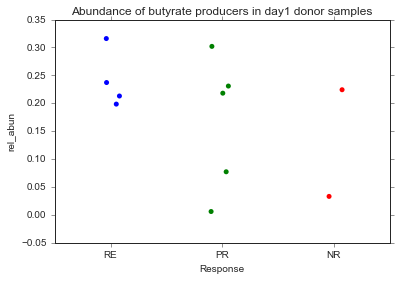

In [60]:
sns.stripplot(data=donor_but, x='Response', y='rel_abun')
plt.title('Abundance of butyrate producers in day1 donor samples')

Hm.. why are there only 2 non-responders again? Paper looks like there should be 4 in the FMT group.

In [61]:
print('Non responders, donor data')
(tidydf
     .query('Response == "NR"')
     [['Response', 'DonorID', 'Sampletype', 'Sampling_day']]
     .drop_duplicates()
     .query('Sampletype == "Donorstool"')
     .groupby(['DonorID', 'Sampling_day'])
     .size()
 )

Non responders, donor data


DonorID  Sampling_day
DB       d1              1
DF       d14             1
         d28             1
         d42             1
         d56             1
DI       d14             1
         d28             1
         d42             1
DJ       d1              1
         d14             1
         d28             1
         d42             1
dtype: int64

In [62]:
print('Remission, donor data')
(tidydf
     .query('Response == "RE"')
     [['Response', 'DonorID', 'Sampletype', 'Sampling_day']]
     .drop_duplicates()
     .query('Sampletype == "Donorstool"')
     .groupby(['DonorID', 'Sampling_day'])
     .size()
 )

Remission, donor data


DonorID  Sampling_day
DC       d1              1
         d42             1
         d56             1
DG       d1              1
         d14             1
         d28             1
         d42             1
         d56             1
DK       d1              1
         d28             1
         d42             1
DL       d1              1
         d14             1
         d28             1
         d42             1
         d56             1
dtype: int64

Ah, looks like two of the donors only have d14 samples. Let's make the same plot but at day 14.

In [63]:
donor_but_d14 = (
    tidydf
        .query('otu_id_gg == @but_gg')
        .query('Sampletype == "Donorstool"')
        .query('Sampling_day == "d14"')
        .groupby(['sample_id', 'DonorID', 'Sampling_day', 'Response'])
        .sum()
        ['rel_abun']
    ).reset_index()
donor_but_d14.sort_values(by='Response')

,sample_id,DonorID,Sampling_day,Response,rel_abun
2,157,DI,d14,NR,0.093810
3,172,DJ,d14,NR,0.306749
9,96,DF,d14,NR,0.155884
1,142,DC,d14,PR,0.209641
5,217,DM,d14,PR,0.182212
6,235,DN,d14,PR,0.020404
7,67,DD,d14,PR,0.146316
8,83,DE,d14,PR,0.301205
0,113,DG,d14,RE,0.243056
4,200,DL,d14,RE,0.227198


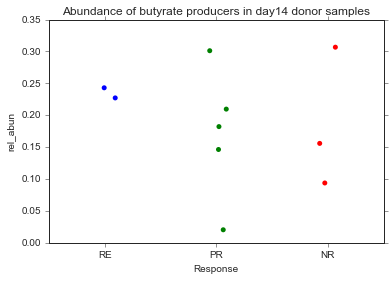

In [64]:
sns.stripplot(data=donor_but_d14, x='Response', y='rel_abun')
plt.title('Abundance of butyrate producers in day14 donor samples')

Ah, and on day 14 we only have two of the remission patients. Maybe I should take the average abundance in the donors? Yes, I think this is ok - because each patient got multiple FMTs, presumably from each of these samples.

In [65]:
donor_but_avg = (
    (
    tidydf
        .query('otu_id_gg == @but_gg')
        .query('Sampletype == "Donorstool"')
        .groupby(['sample_id', 'DonorID', 'PatientID', 'Sampling_day', 'Response'])
        .sum()
        ['rel_abun']
    )
    .reset_index()
    .groupby(['DonorID', 'Response', 'PatientID'])
    .mean()
    ['rel_abun']
).reset_index()
donor_but_avg.sort_values(by='Response')

,DonorID,Response,PatientID,rel_abun
0,DB,NR,PD,0.033156
5,DF,NR,PH,0.217467
7,DI,NR,PL,0.184967
8,DJ,NR,PM,0.235323
1,DC,PR,PK,0.272217
3,DD,PR,PF,0.178973
4,DE,PR,PG,0.336652
11,DM,PR,PP,0.143828
12,DN,PR,PQ,0.029551
2,DC,RE,PE,0.218528


Yes, this is correct - there is data for 13 patients in the FMT group (because there were 17 total, but 4 did not get microbiome data analysis bc they were not per protocol, from Fig S2).

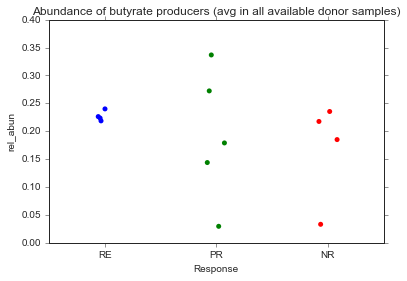

In [66]:
sns.stripplot(data=donor_but_avg, x='Response', y='rel_abun', order=['RE', 'PR', 'NR'])
plt.title('Abundance of butyrate producers (avg in all available donor samples)')

In [67]:
import statsmodels.stats.api as sms

x1 = donor_but_avg.query('Response == "RE"')['rel_abun']
x2 = donor_but_avg.query('Response == "NR"')['rel_abun']

cm = sms.CompareMeans(sms.DescrStatsW(x1), sms.DescrStatsW(x2))
print cm.tconfint_diff(usevar='unequal')

(-0.086360559342242738, 0.20498994040291585)


This says that the true difference in means is anywhere from -0.8 (which doesn't make sense with these units) and 0.2...?

Let's just plot the abundance of butyrate producers (from GG) in all the donor samples...

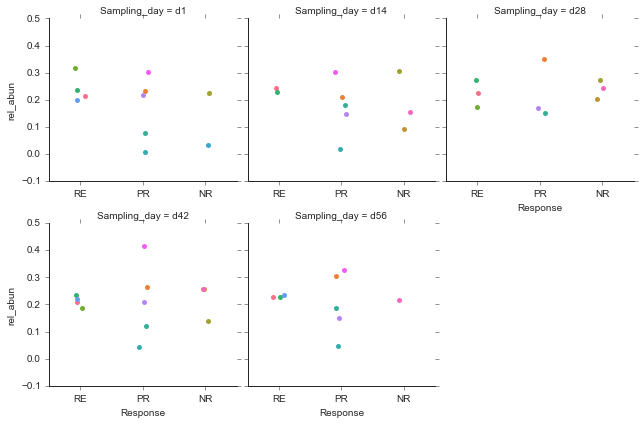

In [68]:
# First, get the abundance of all butyrate producers in each sample
donor_butyrate_all = (tidydf
     .query('otu_id_gg == @but_gg')
     .query('Sampletype == "Donorstool"')
     .groupby(['sample_id', 'DonorID', 'PatientID', 'Sampling_day', 'Response'])
     .sum()
     ['rel_abun']
).reset_index()


g = sns.FacetGrid(col='Sampling_day', data=donor_butyrate_all, col_wrap=3, hue='PatientID', sharex=False)
g.map(sns.stripplot, 'Response', 'rel_abun', jitter=True, order=['RE', 'PR', 'NR'])

In [85]:
import numpy as np
tmp = donor_butyrate_all.groupby(['DonorID', 'Response', 'PatientID']).mean()['rel_abun'].reset_index()
tmp['Sampling_day'] = np.nan
tmp['sample_id'] = np.nan
pd.concat((tmp, donor_butyrate_all), sort=False)

,DonorID,Response,PatientID,rel_abun,Sampling_day,sample_id
0,DB,NR,PD,0.033156,NaN,NaN
1,DC,PR,PK,0.272217,NaN,NaN
2,DC,RE,PE,0.218528,NaN,NaN
3,DD,PR,PF,0.178973,NaN,NaN
4,DE,PR,PG,0.336652,NaN,NaN
5,DF,NR,PH,0.217467,NaN,NaN
6,DG,RE,PI,0.223485,NaN,NaN
7,DI,NR,PL,0.184967,NaN,NaN
8,DJ,NR,PM,0.235323,NaN,NaN
9,DK,RE,PN,0.226192,NaN,NaN


What about the SILVA abundance?

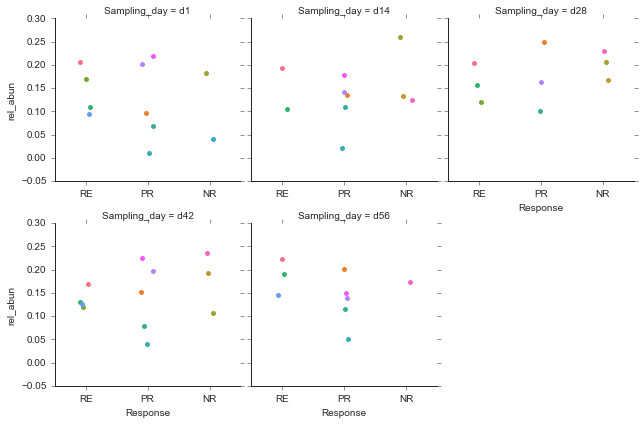

In [69]:
# First, get the abundance of all butyrate producers in each sample
donor_butyrate_all_silva = (tidydf
     .query('otu_id_silva == @but_silva')
     .query('Sampletype == "Donorstool"')
     .groupby(['sample_id', 'DonorID', 'PatientID', 'Sampling_day', 'Response'])
     .sum()
     ['rel_abun']
).reset_index()

# FacetGrid breaks if I hadd hue='PatientID' - it loses the x-axis...

g = sns.FacetGrid(col='Sampling_day', data=donor_butyrate_all_silva, col_wrap=3, hue='PatientID', sharex=False)
g.map(sns.stripplot, 'Response', 'rel_abun', jitter=True, order=['RE', 'PR', 'NR'])

## Donor-patient pair comparisons

Can I compare preFMT patients with their donor?

In [70]:
tidydf['prepost'].unique()

array(['Donorstool', 'postFMT', 'preABX', 'postABX', 'control'], dtype=object)

In [71]:
pt_but = (tidydf
    .query('otu_id_gg == @but_gg')
    .query('Sampletype == "Patientstool"')
    #.query('(prepost == "preABX") | (prepost == "postABX")')
    .query('(prepost == "preABX")')
    .groupby(['sample_id', 'PatientID', 'DonorID', 'Sampling_day', 'Response'])
    .sum()
    ['rel_abun']
).reset_index().rename(columns={'rel_abun': 'rel_abun_pt_preabx'})
pt_but

,sample_id,PatientID,DonorID,Sampling_day,Response,rel_abun_pt_preabx
0,104,PI,DG,d-10,RE,0.355254
1,151,PL,DI,d-10,NR,0.151200
2,163,PM,DJ,d-10,NR,0.162825
3,226,PQ,DN,d-10,PR,0.193063
4,242,CA,Control,d-10,Control,0.170843
5,245,CB,Control,d-10,Control,0.262100
6,248,CC,Control,d-10,Control,0.101187
7,252,CD,Control,d-10,Control,0.242607
8,253,CE,Control,d-10,Control,0.191136
9,257,CF,Control,d-10,Control,0.192086


Not every patient has the preABX sample... Might need to just keep the ones who we do have that for...

In [72]:
donor_but = donor_but.rename(columns={'rel_abun': 'rel_abun_donor_d1'})

In [73]:
donor_but

,sample_id,DonorID,Sampling_day,Response,rel_abun_donor_d1
0,112,DG,d1,RE,0.213085
1,141,DC,d1,PR,0.230910
2,171,DJ,d1,NR,0.224305
3,184,DK,d1,RE,0.316036
4,199,DL,d1,RE,0.237211
5,216,DM,d1,PR,0.077284
6,234,DN,d1,PR,0.006068
7,41,DB,d1,NR,0.033156
8,51,DC,d1,RE,0.198557
9,66,DD,d1,PR,0.218151


In [74]:
pt_donor_but = pd.merge(
    donor_but[['DonorID', 'Response', 'rel_abun_donor_d1']], 
    pt_but[['DonorID', 'Response', 'rel_abun_pt_preabx']],
    left_on='DonorID',
    right_on='DonorID', 
    how='outer')

In [75]:
pt_donor_but.sort_values(by='DonorID')

,DonorID,Response_x,rel_abun_donor_d1,Response_y,rel_abun_pt_preabx
19,Control,NaN,NaN,Control,0.322813
18,Control,NaN,NaN,Control,0.048404
17,Control,NaN,NaN,Control,0.192086
16,Control,NaN,NaN,Control,0.191136
15,Control,NaN,NaN,Control,0.242607
20,Control,NaN,NaN,Control,0.186478
14,Control,NaN,NaN,Control,0.101187
12,Control,NaN,NaN,Control,0.170843
13,Control,NaN,NaN,Control,0.262100
8,DB,NR,0.033156,NR,0.231831


Okay, so looks like: 

- none of the controls have donor d1 data (obvs, since they didn't get FMT)
- missing patient preABX data: donors DD, DE, DK, DL, DM
- missing donor d1 data: patient that went with donor DF

In [76]:
# Difference between patient preABX and donor butyrate abundance
pt_donor_but['donor_minus_pt'] = pt_donor_but['rel_abun_donor_d1'] - pt_donor_but['rel_abun_pt_preabx']

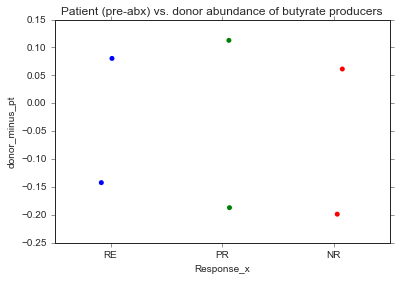

In [77]:
sns.stripplot(data=pt_donor_but, x='Response_x', y='donor_minus_pt')
plt.title('Patient (pre-abx) vs. donor abundance of butyrate producers')

shnope - that looks pretty not-different between the groups!

What about post-ABX patient butyrate producer abundance??

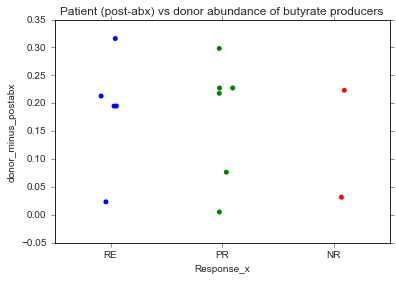

In [78]:
postabx_but = (tidydf
    .query('otu_id_gg == @but_gg')
    .query('Sampletype == "Patientstool"')
    .query('(prepost == "postABX")')
    .groupby(['sample_id', 'PatientID', 'DonorID', 'Sampling_day', 'Response'])
    .sum()
    ['rel_abun']
).reset_index().rename(columns={'rel_abun': 'rel_abun_pt_postabx'})

postabx_donor_but = pd.merge(
    donor_but[['DonorID', 'Response', 'rel_abun_donor_d1']], 
    postabx_but[['DonorID', 'Response', 'rel_abun_pt_postabx']],
    left_on='DonorID',
    right_on='DonorID', 
    how='outer')

# Difference btw postabx and donor butyrate producer abun
postabx_donor_but['donor_minus_postabx'] = (
    postabx_donor_but['rel_abun_donor_d1'] - postabx_donor_but['rel_abun_pt_postabx']
    )

sns.stripplot(data=postabx_donor_but, x='Response_x', y='donor_minus_postabx')
plt.title('Patient (post-abx) vs donor abundance of butyrate producers')

Hah interesting - abx kills all the butyrate producers! Not really any differences between the responders though.

# Conclusions

From looking at the abundance of butyrate producers in donors (across all sampling days): there doesn't seem to be clear differences between remission/partial responders/no response.
- these are the facet grid plots

Nothing comes out of looking at the paired patient/donor samples (i.e. looking at the difference in relative abundance of butyrate producers btw patient pre-FMT and donor d1)

And an important caveat: I'm not totally confident in my assignment of butyrate-production. Most of my assignments were at the genus level (based on Marius Vital's two papers), but they don't match exactly that paper.

# Next steps

Looking at the abundance of butyrate producers in the donors doesn't look great. Let's look in another dataset and then show Eric the results...